In [1]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/encoded.csv', index_col=0)
df.head()

,date,time,district,n_p,dtp_v,s_pch,osv,change_org_motion,woman_drv,pogoda,driver_narush,alco,posled,sdor
0,2015-05-12,09:20:00,КАШАРСКИЙ,сл Кашары,1,1,2,2,1,1,1,0,1,5
1,2016-03-09,17:20:00,КАШАРСКИЙ,NaN,0,1,2,2,0,1,1,0,1,5
2,2018-08-19,17:40:00,КАШАРСКИЙ,NaN,0,1,2,2,0,1,1,0,0,5
3,2018-08-08,14:15:00,КАШАРСКИЙ,NaN,0,1,2,2,1,1,1,0,1,5
4,2015-03-07,21:15:00,КАШАРСКИЙ,NaN,1,1,0,1,0,1,1,1,2,5


In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd
import numpy as np
%tensorflow_version 1.x
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

TensorFlow 1.x selected.


Using TensorFlow backend.


In [4]:
dfl = df[df['n_p']=='г Москва']
dfl = dfl[['date']].copy()
dfl['y'] = 1
dfl.head()
dfl.date = pd.to_datetime(df.date)
dfl.head()

,date,y
181753,2018-12-25,1
181769,2015-01-21,1
181774,2015-07-08,1
181778,2015-04-10,1
181788,2015-03-30,1


In [ ]:
df = df.sort_values(by=['date'])
df = df[['date']].copy()
df['y'] = 1
df.date = pd.to_datetime(df.date)
df.head()

,date,y
343040,2015-01-01,1
539432,2015-01-01,1
539433,2015-01-01,1
459293,2015-01-01,1
529159,2015-01-01,1


In [12]:
y = dfl.groupby(pd.Grouper(key='date',freq='W')).count()
y

,y
date,
2015-01-04,75
2015-01-11,121
2015-01-18,182
2015-01-25,175
2015-02-01,173
...,...
2019-11-03,168
2019-11-10,223
2019-11-17,182


In [13]:
split_date ='2019-08-04'
df_training = y.loc[y.index <= split_date]
df_test = y.loc[y.index > split_date]
print(f"{len(df_training)} month of training data \n {len(df_test)} month of testing data ")

240 month of training data 
 17 month of testing data 


In [7]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'Средняя абсолютная процентная ошибка':mape, 'Средняя ошибка':me, 'Средняя абсолютная ошибка': mae, 
            'Средняя ошибка в процентах': mpe, 'Среднеквадратичная ошибка':rmse, #'acf1':acf1, 
            'Соотношение фактического и прогноза':corr, 'Мин-макс ошибка':minmax})

# LSTM 

# Помесячное прогнозирование значений ДТП

## По РФ

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_training)
scaled_train_data = scaler.transform(df_training)
scaled_test_data = scaler.transform(df_test)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(12, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 12)                672       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
35/35 [==============================] - 1s 28ms/step - loss: 0.2990
Epoch 2/20
35/35 [==============================] - 0s 5ms/step - loss: 0.1882
Epoch 3/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0923
Epoch 4/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0722
Epoch 5/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0625
Epoch 6/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0520
Epoch 7/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 8/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0343
Epoch 9/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 10/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0168
Epoch 11/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 12/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 13/20
35/35 [=============================

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(df_test)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[13784.89],
       [12183.77],
       [11447.36],
       [11091.43],
       [11469.35],
       [12441.81],
       [13657.91],
       [14910.12],
       [15916.44],
       [16126.31],
       [15491.9 ],
       [14296.32]])

In [ ]:
df_test['LSTM_Predictions'] = lstm_predictions
df_test

,y,LSTM_Predictions
date,,
2018-12-31,15244,"13,784.89"
2019-01-31,11683,"12,183.77"
2019-02-28,9731,"11,447.36"
2019-03-31,10514,"11,091.43"
2019-04-30,10988,"11,469.35"
2019-05-31,13226,"12,441.81"
2019-06-30,14568,"13,657.91"
2019-07-31,15135,"14,910.12"
2019-08-31,15907,"15,916.44"


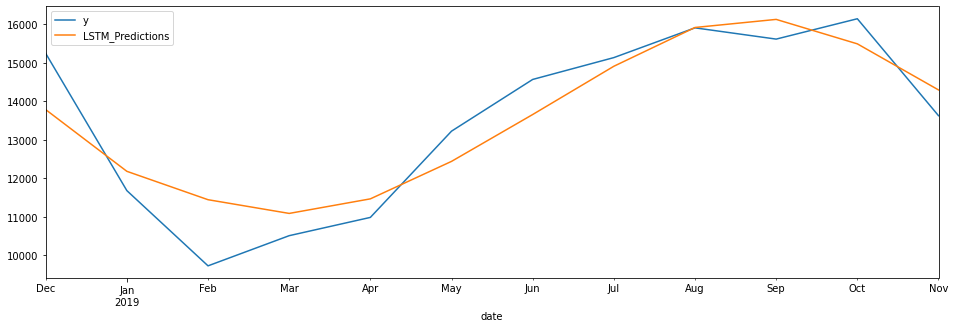

In [ ]:
df_test['y'].plot(figsize = (16,5), legend=True)
df_test['LSTM_Predictions'].plot(legend = True);

In [ ]:
lstm_rmse_error = rmse(df_test['y'], df_test["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df_test['y'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 709725.2730631833
RMSE Error: 842.4519411000151
Mean: 13531.833333333334


## По Москве

47 12
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Ep

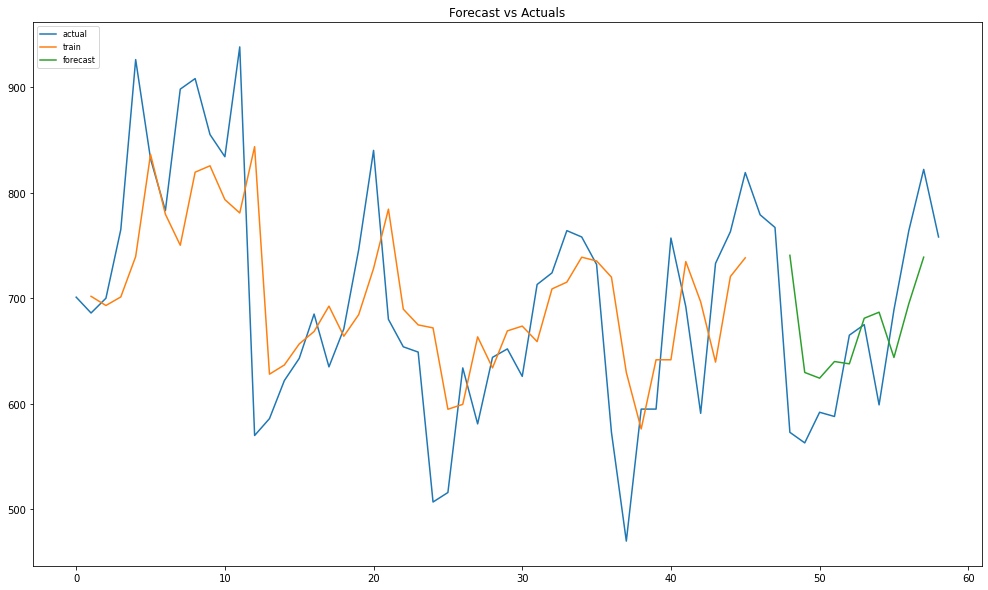

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(y.values)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(14, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=3, verbose=3)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(17,10))
plt.plot(scaler.inverse_transform(dataset),label='actual')
plt.plot(trainPredictPlot, label='train')
plt.plot(testPredictPlot,label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 12)                672       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
35/35 [==============================] - 2s 57ms/step - loss: 0.1864
Epoch 2/20
35/35 [==============================] - 0s 8ms/step - loss: 0.0902
Epoch 3/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0489
Epoch 4/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0391
Epoch 5/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 6/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0349
Epoch 7/20
35/35 [========================

{'Мин-макс ошибка': 0.08109835565936585,
 'Соотношение фактического и прогноза': 0.8443471851998918,
 'Среднеквадратичная ошибка': 67.76051462764887,
 'Средняя абсолютная ошибка': 57.93618096907934,
 'Средняя абсолютная процентная ошибка': 0.08760810311295657,
 'Средняя ошибка': 17.085377156734467,
 'Средняя ошибка в процентах': 0.02335845906936874}

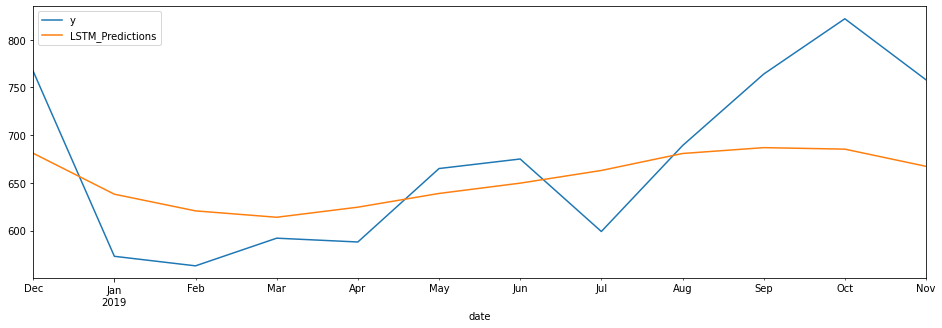

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df_training)
scaled_train_data = scaler.transform(df_training)
scaled_test_data = scaler.transform(df_test)

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(12, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

lstm_model.fit_generator(generator,epochs=20)

lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(df_test)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

df_test['LSTM_Predictions'] = lstm_predictions
df_test

df_test['y'].plot(figsize = (16,5), legend=True)
df_test['LSTM_Predictions'].plot(legend = True);
lstm_rmse_error = rmse(df_test['y'], df_test["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df_test['y'].mean()

forecast_accuracy(df_test['y'], df_test["LSTM_Predictions"])

# Посуточное прогнозирование значений ДТП

## По РФ

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df_training)
scaled_train_data = scaler.transform(df_training)
scaled_test_data = scaler.transform(df_test)

In [ ]:
n_input = 30
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(30, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 30)                3840      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
1735/1735 [==============================] - 20s 12ms/step - loss: 0.0144
Epoch 2/20
1735/1735 [==============================] - 19s 11ms/step - loss: 0.0100
Epoch 3/20
1735/1735 [==============================] - 20s 11ms/step - loss: 0.0095
Epoch 4/20
1735/1735 [==============================] - 19s 11ms/step - loss: 0.0090
Epoch 5/20
1735/1735 [==============================] - 19s 11ms/step - loss: 0.0085
Epoch 6/20
1735/1735 [==============================] - 19s 11ms/step - loss: 0.0085
Epoch 7/20
1735/1735 [==============================] - 19s 11ms/step - loss: 0.0083
Epoch 8/20
1735/1735 [==============================] - 19s 11ms/step - loss: 0.0080
Epoch 9/20
1735/1735 [==============================] - 20s 11ms/step - loss: 0.0075
Epoch 10/20
1735/1735 [==============================] - 19s 11ms/step - loss: 0.0074
Epoch 11/20
1735/1735 [==============================] - 19s 11ms/step - loss: 0.0072
Epoch 12/20
1735/1735 [==============================] - 19s 11

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(df_test)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[513.14],
       [558.22],
       [549.77],
       [522.81],
       [503.52],
       [493.38],
       [498.26],
       [536.06],
       [576.17],
       [563.45],
       [530.73],
       [515.11],
       [503.9 ],
       [507.2 ],
       [532.18],
       [568.83],
       [578.09],
       [543.55],
       [520.53],
       [501.56],
       [502.43],
       [531.28],
       [581.75],
       [581.86],
       [542.14],
       [521.05],
       [504.6 ],
       [503.58],
       [524.68],
       [581.27]])

In [ ]:
df_test['LSTM_Predictions'] = lstm_predictions
df_test

,y,LSTM_Predictions
date,,
2019-11-01,543,513.14
2019-11-02,491,558.22
2019-11-03,428,549.77
2019-11-04,366,522.81
2019-11-05,525,503.52
2019-11-06,496,493.38
2019-11-07,455,498.26
2019-11-08,489,536.06
2019-11-09,454,576.17


MSE Error: 10382.344509525872
RMSE Error: 101.89379033840027
Mean: 454.26666666666665


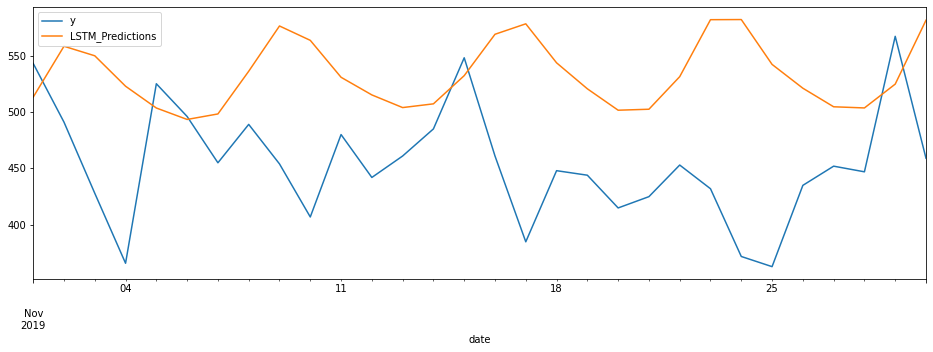

In [ ]:
df_test['y'].plot(figsize = (16,5), legend=True)
df_test['LSTM_Predictions'].plot(legend = True);
lstm_rmse_error = rmse(df_test['y'], df_test["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df_test['y'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

In [ ]:
forecast_accuracy(df_test['y'], df_test["LSTM_Predictions"])

{'Мин-макс ошибка': 0.15794417354587165,
 'Соотношение фактического и прогноза': -0.3106294397972154,
 'Среднеквадратичная ошибка': 101.89379033840027,
 'Средняя абсолютная ошибка': 86.24355815649032,
 'Средняя абсолютная процентная ошибка': 0.1583392465331485,
 'Средняя ошибка': -78.76981367270152,
 'Средняя ошибка в процентах': -0.14390200449009158}

## По Москве

1765 30
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Train Score: 6.39 RMSE
Test Score: 6.81 RMSE


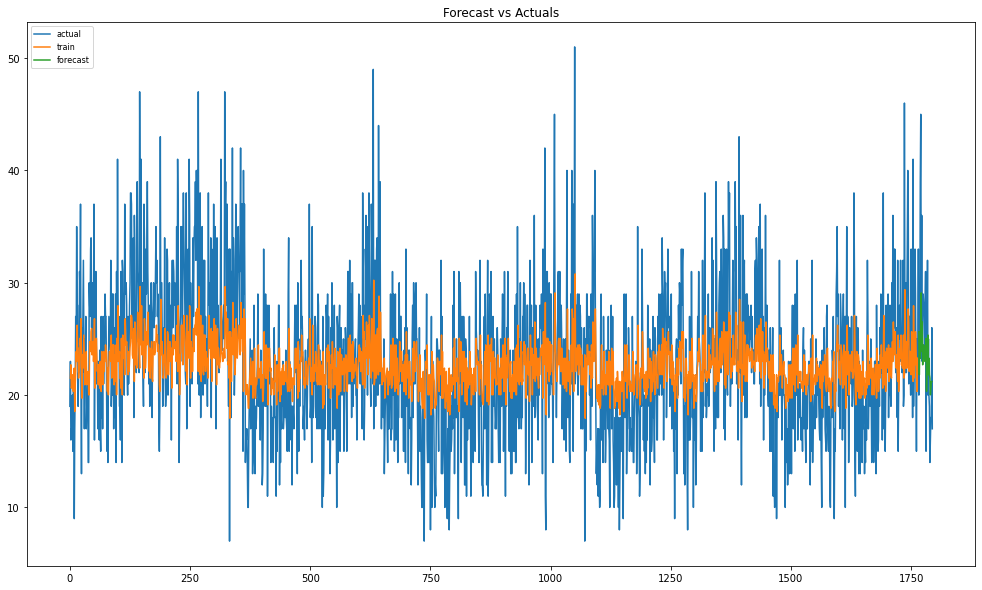

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(y.values)

train_size = int(len(dataset) * 0.9837)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(30, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=30, batch_size=3, verbose=3)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(17,10))
plt.plot(scaler.inverse_transform(dataset),label='actual')
plt.plot(trainPredictPlot, label='train')
plt.plot(testPredictPlot,label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Понедельное прогнозирование значений ДТП

### По РФ

# 1 способ

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(y.values)

train_size = int(len(dataset) * 0.9339)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(17, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=3, verbose=3)

240 17
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
E

Train Score: 256.40 RMSE
Test Score: 212.19 RMSE


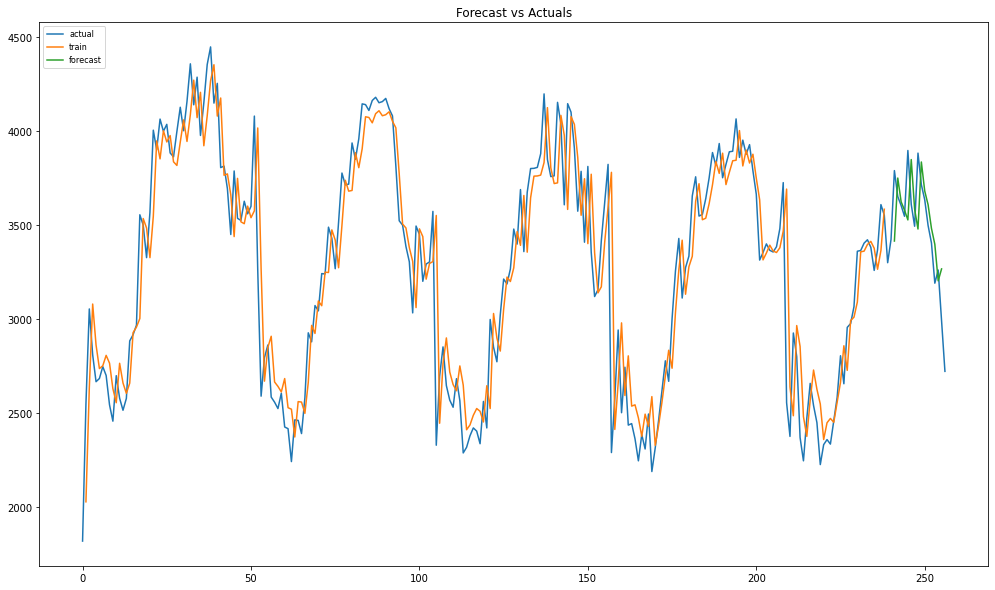

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(17,10))
plt.plot(scaler.inverse_transform(dataset),label='actual')
plt.plot(trainPredictPlot, label='train')
plt.plot(testPredictPlot,label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df_training)
scaled_train_data = scaler.transform(df_training)
scaled_test_data = scaler.transform(df_test)

n_input = 17
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(17, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 17)                1292      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 18        
Total params: 1,310
Trainable params: 1,310
Non-trainable params: 0
_________________________________________________________________


Epoch 1/17
223/223 [==============================] - 3s 15ms/step - loss: 0.0440
Epoch 2/17
223/223 [==============================] - 2s 8ms/step - loss: 0.0200
Epoch 3/17
223/223 [==============================] - 2s 8ms/step - loss: 0.0140
Epoch 4/17
223/223 [==============================] - 2s 8ms/step - loss: 0.0118
Epoch 5/17
223/223 [==============================] - 2s 8ms/step - loss: 0.0103
Epoch 6/17
223/223 [==============================] - 2s 8ms/step - loss: 0.0104
Epoch 7/17
223/223 [==============================] - 2s 8ms/step - loss: 0.0106
Epoch 8/17
223/223 [==============================] - 2s 8ms/step - loss: 0.0091
Epoch 9/17
223/223 [==============================] - 2s 8ms/step - loss: 0.0098
Epoch 10/17
223/223 [==============================] - 2s 8ms/step - loss: 0.0093
Epoch 11/17
223/223 [==============================] - 2s 8ms/step - loss: 0.0094
Epoch 12/17
223/223 [==============================] - 2s 8ms/step - loss: 0.0098
Epoch 13/17
223/223 [===

{'Мин-макс ошибка': 0.07727606586942037,
 'Соотношение фактического и прогноза': 0.7098579535412947,
 'Среднеквадратичная ошибка': 320.68755617505843,
 'Средняя абсолютная ошибка': 277.7681685230308,
 'Средняя абсолютная процентная ошибка': 0.08528112074303851,
 'Средняя ошибка': 231.77394261780861,
 'Средняя ошибка в процентах': 0.07026729225759462}

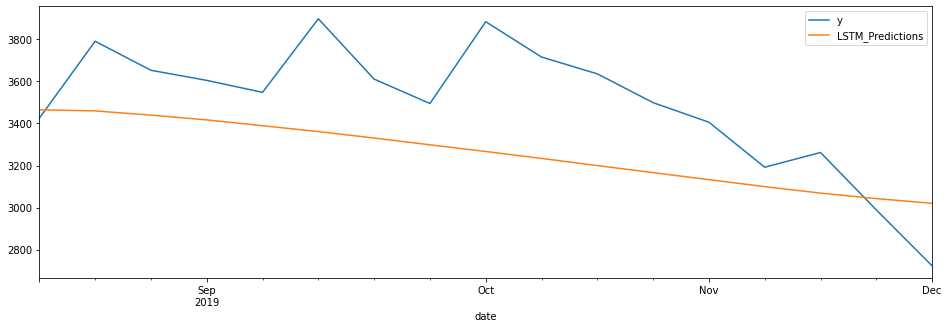

In [ ]:
lstm_model.fit_generator(generator,epochs=17)

lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(df_test)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

df_test['LSTM_Predictions'] = lstm_predictions
df_test

df_test['y'].plot(figsize = (16,5), legend=True)
df_test['LSTM_Predictions'].plot(legend = True);
lstm_rmse_error = rmse(df_test['y'], df_test["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df_test['y'].mean()

forecast_accuracy(df_test['y'], df_test["LSTM_Predictions"])

## По Москве

### 1 способ

240 17
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
E

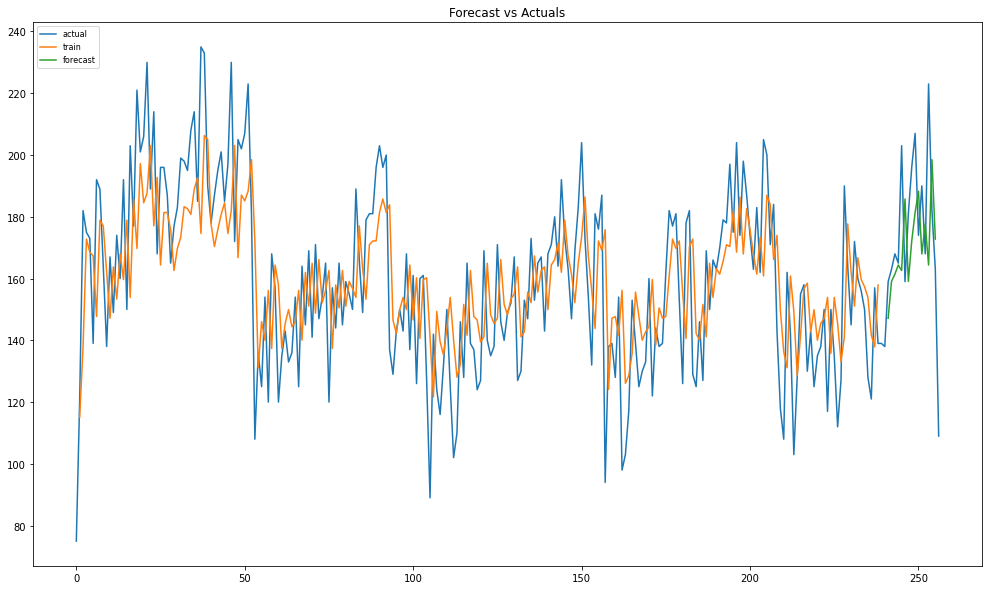

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(y.values)

train_size = int(len(dataset) * 0.9339)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(17, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=3, verbose=3)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(17,10))
plt.plot(scaler.inverse_transform(dataset),label='actual')
plt.plot(trainPredictPlot, label='train')
plt.plot(testPredictPlot,label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()